In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from estimark.agents import PortfolioLifeCycleConsumerType
from estimark.parameters import init_calibration
from estimark.snp import snp_data, snp_data_full
from HARK.utilities import plot_funcs

In [2]:
csv_file_path = "../../content/tables/TRP/Portfolio_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
res = res.set_index(res.columns[0])[res.columns[1]].to_dict()

In [3]:
portfolio_agent = PortfolioLifeCycleConsumerType(**init_calibration)
portfolio_agent.CRRA = float(res["CRRA"])
portfolio_agent.update()
portfolio_agent.CRRA, portfolio_agent.DiscFac

(8.809736592657766, 1.0)

In [4]:
portfolio_agent.solve()

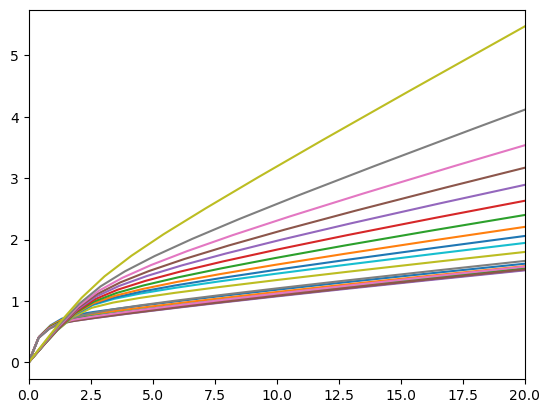

In [5]:
plot_funcs([sol.cFunc for sol in portfolio_agent.solution[:-1:5]], 0, 20)

In [6]:
portfolio_agent.ShareLimit

array([0.10240661])

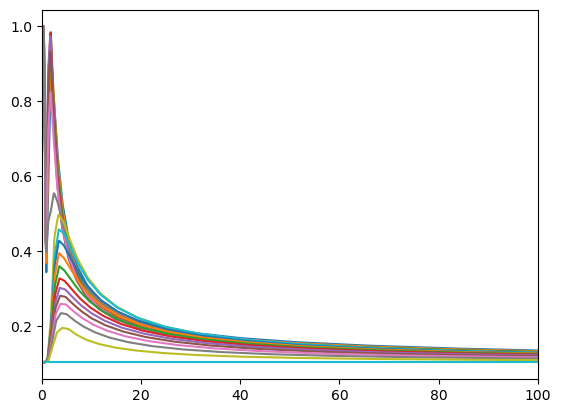

In [7]:
plot_funcs(
    [
        *[sol.ShareFuncAdj for sol in portfolio_agent.solution[:-1:5]],
        lambda m: portfolio_agent.ShareLimit * np.ones_like(m),
    ],
    0,
    100,
)

In [8]:
# Set up the variables we want to keep track of.
portfolio_agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm", "Share"]

portfolio_agent.LivPrb = [1.0] * portfolio_agent.T_cycle

portfolio_agent.T_sim = portfolio_agent.T_cycle + 1
# Run the simulations
portfolio_agent.initialize_sim()
history = portfolio_agent.simulate()

In [9]:
portfolio_agent.T_sim

96

In [10]:
raw_data = {
    "Age": portfolio_agent.history["t_age"].flatten() + 25 - 1,
    "pIncome": portfolio_agent.history["pLvl"].flatten(),
    "nrmM": portfolio_agent.history["mNrm"].flatten(),
    "nrmC": portfolio_agent.history["cNrm"].flatten(),
    "Share": portfolio_agent.history["Share"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

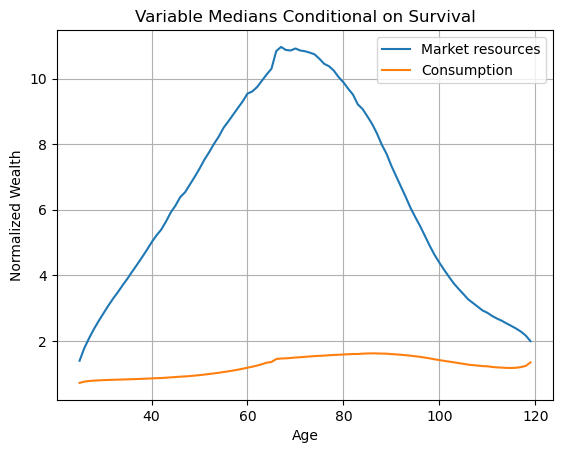

In [11]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.nrmM, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.nrmC, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Normalized Wealth")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

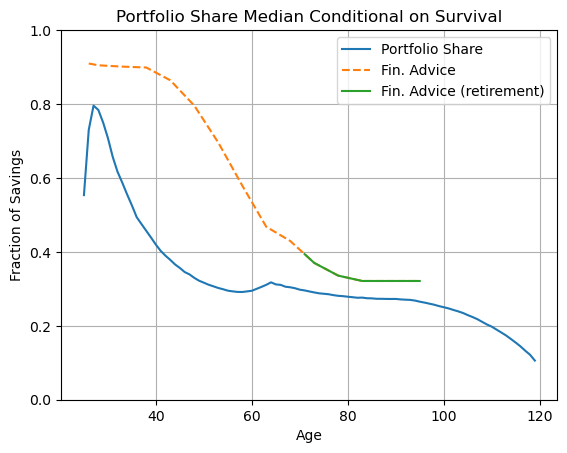

In [12]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.Share, label="Portfolio Share")
plt.plot(
    snp_data_full["age"],
    snp_data_full["share"],
    label="Fin. Advice",
    linestyle="--",
)
plt.plot(snp_data["age"], snp_data["share"], label="Fin. Advice (retirement)")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Fraction of Savings")
plt.title("Portfolio Share Median Conditional on Survival")
plt.ylim(0, 1)
plt.grid()